In [2]:
import seaborn as sns
from matplotlib import font_manager
import numpy as np

font_dirs = ["./"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Roboto", font_scale=1.5)

import pandas as pd 
import wandb
import os
api = wandb.Api()

# Project is specified by <entity/project-name>
wandb.login(host='https://genentech.wandb.io', key=os.environ.get('WANDB_API_KEY'))
runs = api.runs("huang-kexin/active_gears")

name2res = {}
name2steps = {}
name_list = []
for run in runs: 
   
    if 'batch_exp' in run.name:
        method_name = run.name
        name2res[method_name] = {}
        name2steps[method_name] = {}
        for metric in ['test_round_mse_top20_de_non_dropout', 
                    'test_round_pearson_delta', 
                    'test_round_frac_opposite_direction_top20_non_dropout', 
                    'test_round_mse_non_dropout',
                    'test_round_pearson_delta_top20_de_non_dropout',
                    'test_round_mse_4_non_dropout',
                    'test_round_mse_4_top20_de_non_dropout']:
            name2res[method_name][metric] = [row[metric] for i, row in run.history(keys=[metric]).iterrows()]
    #name2steps[method_name]['#steps'] = max(run.history(keys=['_step'])['_step'])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: huang-kexin. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for genentech.wandb.io to your netrc file: /home/huangk28/.netrc


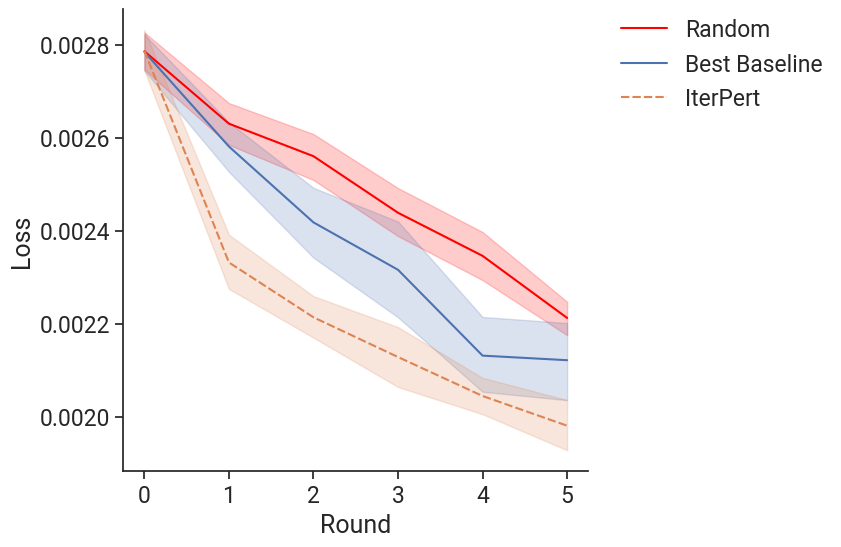

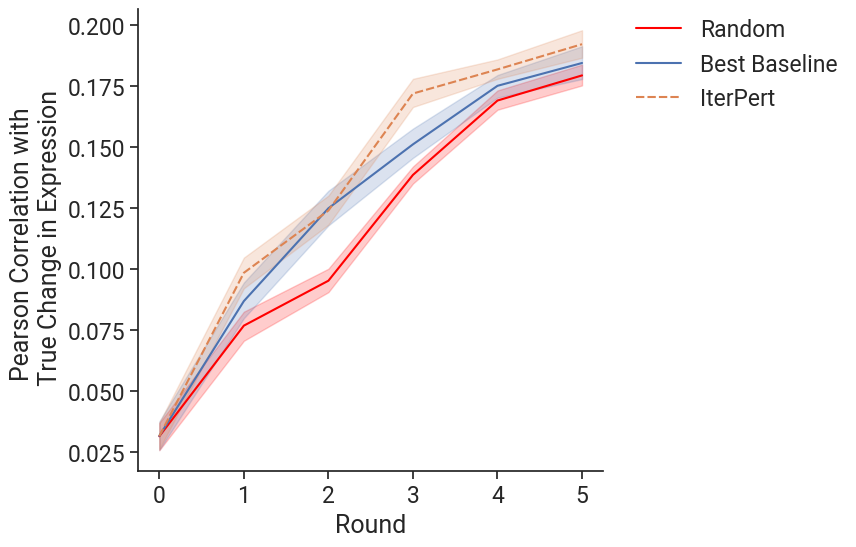

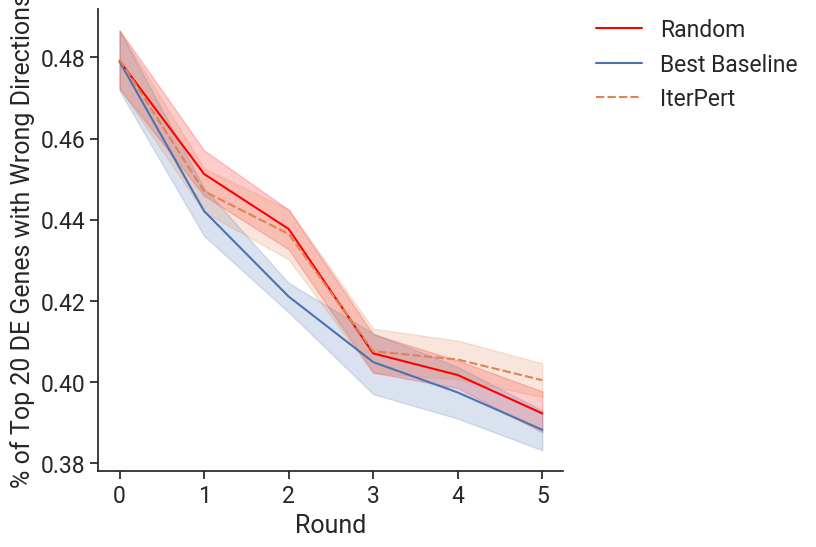

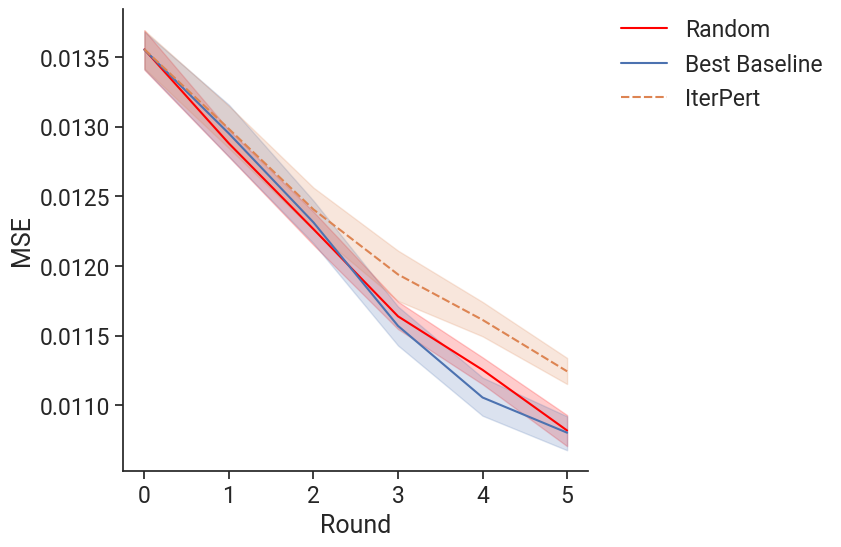

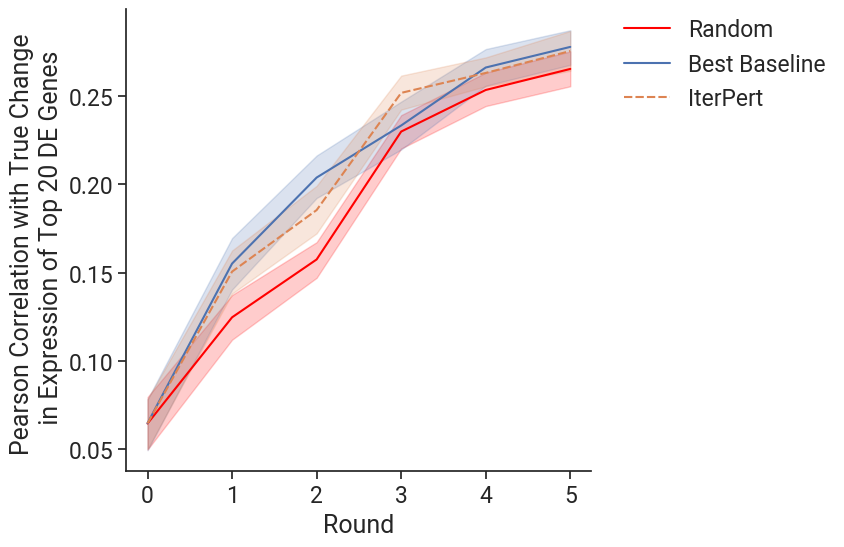

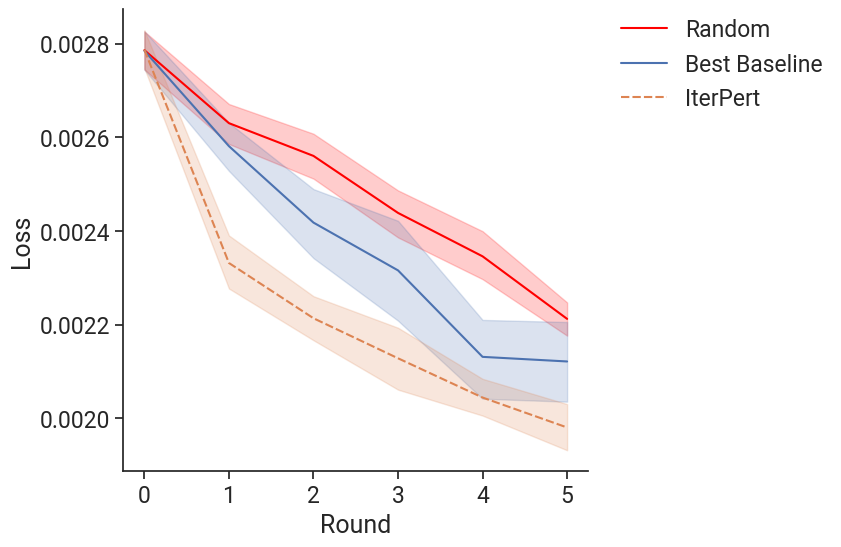

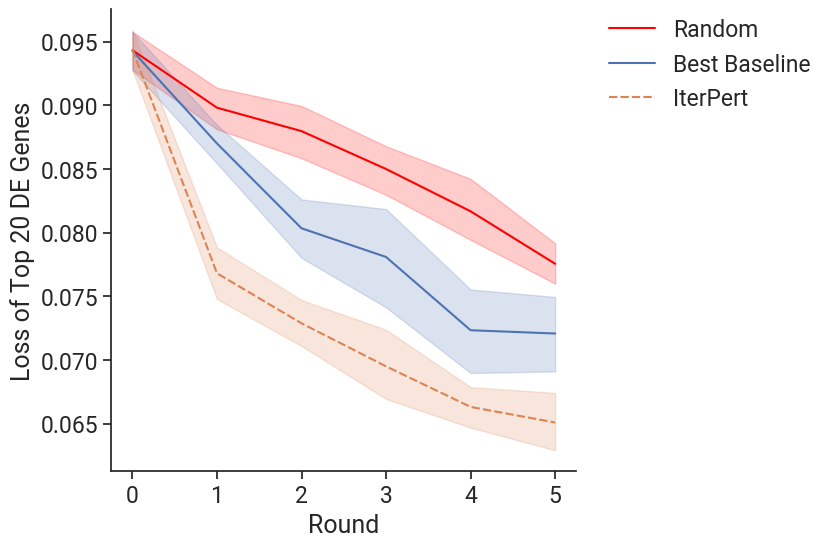

In [6]:
metric2print = {
    'test_round_pearson_delta': 'Pearson Correlation with \n True Change in Expression', 
    'test_round_mse_top20_de_non_dropout': 'MSE of Top 20 DE Genes',
    'test_round_frac_opposite_direction_top20_non_dropout' : '% of Top 20 DE Genes with Wrong Directions', 
    'test_round_mse_non_dropout': 'MSE',
    'test_round_pearson_delta_top20_de_non_dropout': 'Pearson Correlation with True Change \n in Expression of Top 20 DE Genes',
    'test_round_mse_4_non_dropout': 'Loss',
    'test_round_mse_4_top20_de_non_dropout': 'Loss of Top 20 DE Genes'
}
df_metric = pd.DataFrame()

for run in range(1,21):
    method2name = {}
    method2name['Random'] = 'GEARS_100_5_100_256_1_rt_simple_loss_v2_fix_eval_run' + str(run) + '_batch_exp_Random_cross_gene_out'
    #method2name['DIR+Prior'] = 'GEARS_100_5_100_256_1_rt_simple_loss_v2_fix_eval_priormean_new_max_run' + str(run) + '_batch_exp_DIR_diff_effect'
    method2name['Best Baseline'] = 'GEARS_100_5_100_256_1_rt_simple_loss_v2_fix_eval_add_ctrl_run' + str(run) + '_batch_exp_diff_effect_TypiClust'
    method2name['IterPert'] = 'GEARS_100_5_100_256_1_rt_simple_loss_v2_fix_eval_priormean_new_max_run' + str(run) + '_batch_exp_Core-Set_diff_effect'

    name2method = {j:i for i,j in method2name.items()}

    res_list = []
    for method, res in name2res.items():
        if method in list(method2name.values()):
            for metric, values in res.items():
                for idx, val in enumerate(values):
                    res_list.append((idx, val, metric, name2method[method], run))

    df_metric_ind = pd.DataFrame(res_list).rename(columns = {0: 'Round', 1: 'Value', 2: 'Metric', 3: 'Method', 4: 'Run'})
    df_metric_ind = df_metric_ind[df_metric_ind.Round <= 5]
    df_metric = pd.concat((df_metric,df_metric_ind))

import matplotlib.pyplot as plt
method_list = list(method2name.keys())
method_list = [i for i in method_list if i!='Random']
#method_non_random + ['KMeansSampling', 'KMeansSampling_ctrl', 'prior_best']
#method_list = [name_change[i] if i in name_change else i for i in method_list]
for query_metric in ['test_round_mse_4_non_dropout',
                    'test_round_pearson_delta', 
                    'test_round_frac_opposite_direction_top20_non_dropout', 
                    'test_round_mse_non_dropout',
                    'test_round_pearson_delta_top20_de_non_dropout',
                    'test_round_mse_4_non_dropout',
                    'test_round_mse_4_top20_de_non_dropout']:
    sns.lineplot(data = df_metric[(df_metric.Metric == query_metric) & (df_metric.Method.str.contains('Random'))], 
                x = 'Round', y = 'Value', label = 'Random', color = 'red')
    g = sns.lineplot(data = df_metric[(df_metric.Metric == query_metric) & (~df_metric.Method.str.contains('Random'))], 
                    x = 'Round', y = 'Value', hue = 'Method', style='Method', hue_order = method_list, style_order = method_list)
    g.set(ylabel = metric2print[query_metric])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, facecolor='white', framealpha=1, frameon = False)
    sns.despine()
    plt.savefig('./figures/batch_' + query_metric + '.pdf', format='pdf', bbox_inches='tight')
    plt.show()
